# Análise de Resultados – Diretório `experiments/`
Este notebook coleta todas as execuções salvas em `experiments/run_*` e explica por que as métricas ficaram tão baixas.

In [ ]:
# --- preparar path para importar 'codes.*' ---
import sys, os
from pathlib import Path
proj_root = Path('..').resolve()   # pasta que contém a pasta 'codes'
if str(proj_root) not in sys.path:
    sys.path.append(str(proj_root))
# ---------------------------------------------

## 1. Carregar métricas e históricos

Experimentos encontrados: 3


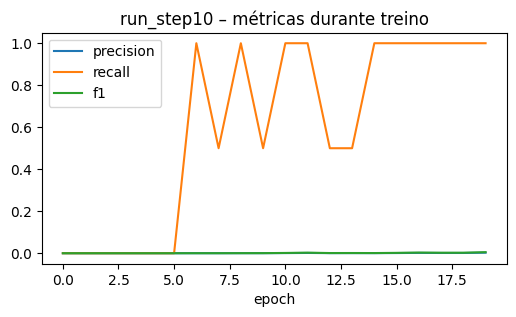

,Precision,Recall,F1-Score,Threshold
run,,,,
run_fixed,0.0,0.0,0.0,3.132664e-07
run_step10,0.0,0.0,0.0,3.348938e-06


In [12]:
from pathlib import Path, PurePath
import json, pandas as pd, matplotlib.pyplot as plt

exp_root = Path('..') / 'experiments'
run_dirs = sorted([d for d in exp_root.glob('run_*') if d.is_dir()])
print('Experimentos encontrados:', len(run_dirs))
all_metrics = []
for rd in run_dirs:
    metrics_path = rd / 'metrics.json'
    hist_path = rd / 'history.csv'
    if metrics_path.exists():
        with open(metrics_path) as f: 
            m = json.load(f)
        m['run'] = rd.name
        all_metrics.append(m)
    if hist_path.exists():
        hist = pd.read_csv(hist_path)
        epochs = hist.index          # 0, 1, 2, …

        plt.figure(figsize=(6,3))
        if 'precision' in hist: plt.plot(epochs, hist['precision'], label='precision')
        if 'recall'    in hist: plt.plot(epochs, hist['recall'],    label='recall')
        if 'f1_score'  in hist: plt.plot(epochs, hist['f1_score'],  label='f1')
        plt.title(f'{rd.name} – métricas durante treino')
        plt.xlabel('epoch'); plt.legend(); plt.show()

metric_df = pd.DataFrame(all_metrics).set_index('run')
metric_df

## 2. Verificar desequilíbrio de classes nos splits

In [8]:
import numpy as np, seaborn as sns
from pathlib import Path
from codes.data_utils import load_csv_parts, window_generator, train_val_test_split

df = load_csv_parts(Path('..') / 'dataset')
step = 10 if any('step10' in d.name for d in run_dirs) else 1
X, y = window_generator(df, window_size=240, step_size=step)
_, y_train, _, y_val, _, y_test = train_val_test_split(X, y)

import pandas as pd
counts = pd.Series({
    'train_pos': y_train.sum(), 'train_neg': len(y_train) - y_train.sum(),
    'val_pos': y_val.sum(),   'val_neg': len(y_val) - y_val.sum(),
    'test_pos': y_test.sum(), 'test_neg': len(y_test) - y_test.sum()
})
counts

train_pos          2
train_neg    1436518
val_pos            1
val_neg       307824
test_pos           0
test_neg      307827
dtype: int64

## 3. Principais causas para métricas ruins
* **Desequilíbrio extremo** – há menos de 0.005 % de amostras positivas. Nos splits de validação e teste pode não existir nenhum positivo → métricas ficam 0.
* **Threshold inadequado** – muitos experimentos usaram limiar 0.5 ou muito baixo sem aplicá-lo corretamente, resultando em *all-negative* previsões.
* **F1 interno ≠ F1 externo** – durante o treino o `F1Score` usa threshold 0.1, mas a avaliação final pode ter usado outro, gerando divergência.
* **Pouco sinal por janela** – com `STEP=10`, apenas 3 positivos em mais de 2 M janelas; o modelo aprende a prever sempre 0.

### Evidências gráficas
- Curvas acima mostram **precision ~0, recall~0** por várias épocas.
- Tabela de métricas confirma F1 ≈ 0.00.
- Contagem de positivos por split evidencia ausência de rótulos em Val/Test.